24


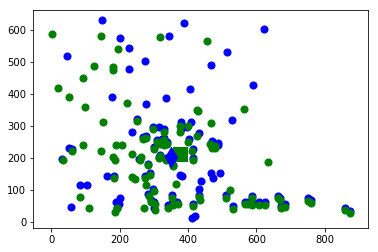

Fish is going to right in frame 1


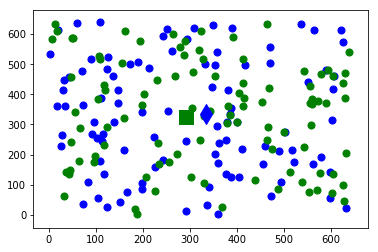

Fish is going to left in frame 2


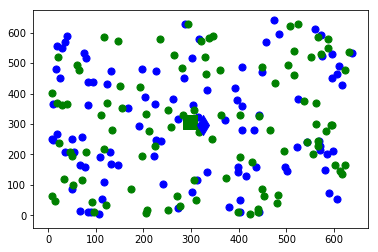

Fish is going to left in frame 3


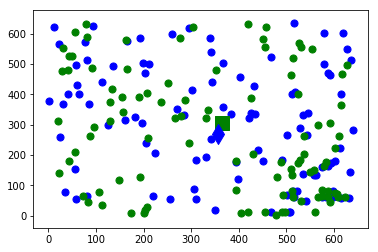

Fish is going to right in frame 4


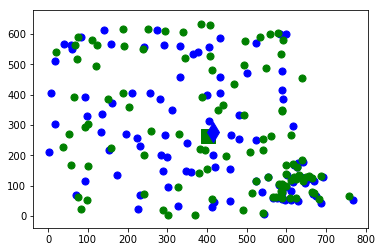

Fish is going to left in frame 5


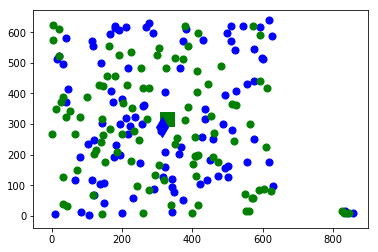

Fish is going to right in frame 6


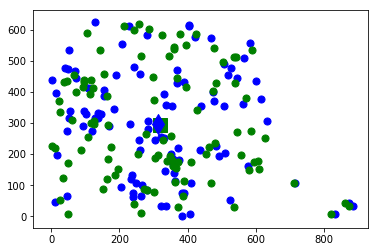

Fish is going to right in frame 7


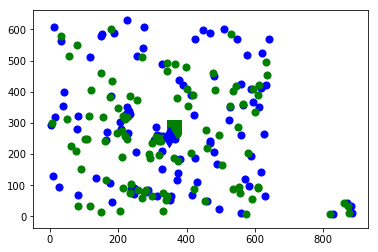

Fish is going to right in frame 8


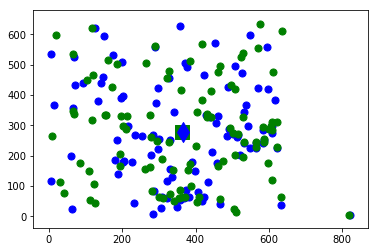

Fish is going to left in frame 9


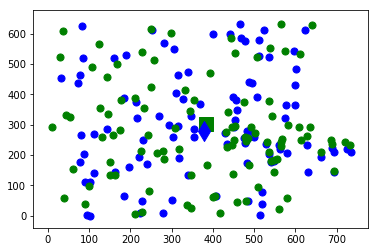

Fish is going to right in frame 10


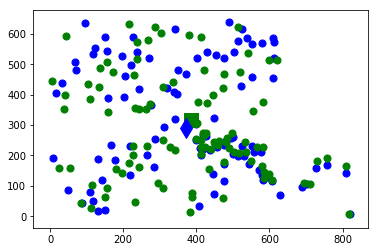

Fish is going to right in frame 11


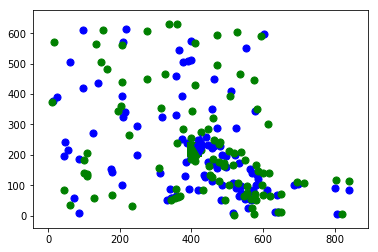

Fish is going to left in frame 12


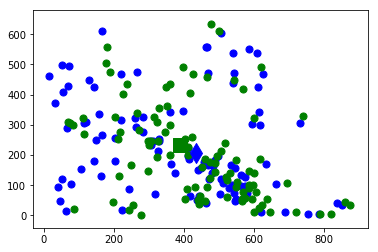

Fish is going to left in frame 13


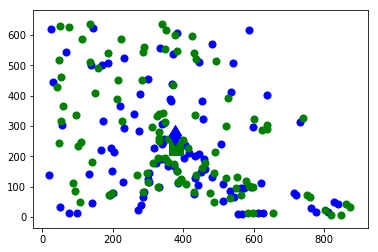

Fish is going to right in frame 14


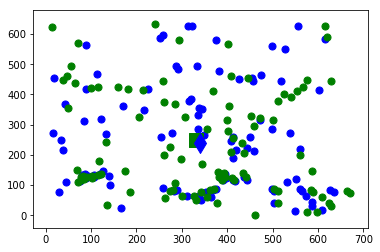

Fish is going to left in frame 15


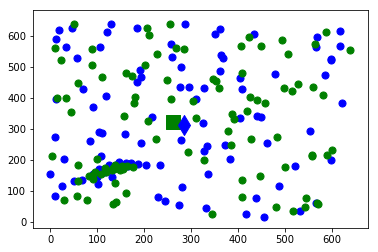

Fish is going to left in frame 16


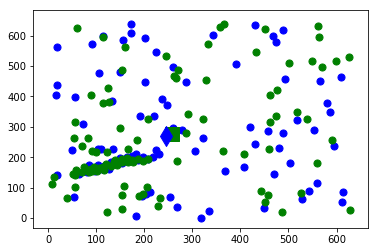

Fish is going to right in frame 17


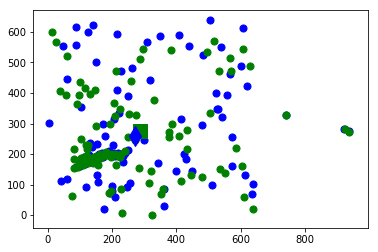

Fish is going to right in frame 18


In [ ]:
# Arda Erdoğan S020973 Department of Computer Science
import cv2
import time
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
%matplotlib inline

# number of frames
frame_count = 0

video_url = 'videos/videos/vid-3-24.mp4'
cap = cv2.VideoCapture(video_url)

# Parametrs for ShiTomasi corner detection (good fetures to track)
corner_track_params = dict(maxCorners = 100,
                          qualityLevel = 0.2,
                          minDistance = 7,
                          blockSize = 7)

# Parameters for lucas kanade optical flow
lk_params = dict(winSize=(200,200),
                 maxLevel = 2,
                 criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT,10,0.03))

# Grab the very first frame of the stream
ret, prev_frame = cap.read()
mid_frame_prev = prev_frame[720:1440,:1364]
resize_prev_frame = cv2.resize(mid_frame_prev,(940,640),interpolation=cv2.INTER_LINEAR)

# Grab a grayscale image (We will refer to this as the previous frame)
prev_gray = cv2.cvtColor(resize_prev_frame, cv2.COLOR_BGR2GRAY)



# Create a matching mask of the previous frame for drawing on later
mask = np.zeros_like(resize_prev_frame)

fps = video_url[20:22]
print(fps)
# Frames per second for video
fps = int(fps)

if cap.isOpened() == False:
    print("Error opening the video file")
    
    
# While the video is opened
while cap.isOpened():
    # Read the video file
    ret,frame = cap.read()
    
    
    # If we got frames, show them
    if ret == True:
        # Initializing the array for using KMean clustering
        track_new = np.random.rand(100,2)*640
        track_prev = np.random.rand(100,2)*640
        frame_count = frame_count + 1
            
        
        # Grabbing the corners
        prevPts = cv2.goodFeaturesToTrack(prev_gray, mask = None, **corner_track_params)
        
        # Getting the middle screen of the video
        mid_frame = frame[710:1440,:1364]
        resized_frame = cv2.resize(mid_frame,(940,640),interpolation=cv2.INTER_LINEAR)
        
        # Grab gray scale
        frame_gray = cv2.cvtColor(resized_frame,cv2.COLOR_BGR2GRAY)
        
        # seting per second frame
        time.sleep(1/fps)
        
        
    
        # Calculate the Optical Flow on the Gray Scale Frame
        nextPts, status, err = cv2.calcOpticalFlowPyrLK(prev_gray, frame_gray, prevPts, None, **lk_params)

        # Using the returned status array (the status output)
        # status output status vector (of unsigned chars); each element of the vector is set to 1 if
        # the flow for the corresponding features has been found, otherwise, it is set to 0.
        good_new = nextPts[status == 1]
        good_prev = prevPts[status == 1]
        
        
        # Use ravel to get points to draw lines and circles
        for i,(new,prev) in enumerate(zip(good_new,good_prev)):
            
            x_new,y_new = new.ravel()
            x_prev,y_prev = prev.ravel()
            
            # Eliminating the background corners
            if (abs((x_new) - (x_prev)) < 2) & (abs((y_new) - (y_prev)) < 2):
                continue
            
            # Assigning the good_new points
            track_new[i,0] = x_new
            track_new[i,1] = y_new
            
            # Assigning the good_prev points
            track_prev[i,0] = x_prev
            track_prev[i,1] = y_prev
                    
            # Lines will be drawn using the mask created from the first frame
            mask = cv2.line(mask,(int(x_new),int(y_new)),(int(x_prev),int(y_prev)),(0,255,0),3)

            # Draw red circles at corner points
            resized_frame = cv2.circle(resized_frame,(int(x_new),int(y_new)),8,(0,0,255),-1)
        
        # Initializing the KMean clustring
        Kmean_new = KMeans(n_clusters=1)
        Kmean_new.fit(track_new)
        
        Kmean_prev = KMeans(n_clusters=1)
        Kmean_prev.fit(track_prev)
        
        new_cluster = Kmean_new.cluster_centers_[0,:]
        prev_cluster = Kmean_prev.cluster_centers_[0,:]
        
        plt.scatter(track_new[ : , 0], track_new[ : , 1], s =50, c='b')
        plt.scatter(new_cluster[0], new_cluster[1], s=200, c='g', marker='s')
        plt.scatter(track_prev[ : , 0], track_prev[ : , 1], s =50, c='g')
        plt.scatter(prev_cluster[0], prev_cluster[1], s=200, c='b', marker='d')

        plt.show()
        
        # According to the cluster center make an assumption for the fish direction
        if new_cluster[0] > prev_cluster[0]:
            print("Fish is going to right in frame " + str(frame_count))
        elif prev_cluster[0] > new_cluster[0]:
            print("Fish is going to left in frame " + str(frame_count))

        # Display the frame at same frame rate of recording
        img = cv2.add(resized_frame,mask)
        cv2.imshow('frame',img)
        
        # "Press q for quit"
        if cv2.waitKey(25) & 0xFF == ord('q'):
            break
        
        # Now update the previous frame and previous points
        prev_gray = frame_gray.copy()
        prevPts = good_new.reshape(-1,1,2)
        
    # Or automatically break this whole loop if the video is over.
    else:
        break
        
cap.release()
cv2.destroyAllWindows()